Detected: Subtask1 format
Total cases: 361

Exploring: train_0001

CT Image Shape: (512, 512, 110)
Segmentation Shape: (512, 512, 110)
CT Value Range: [-1024.0, 3071.0] HU
Unique Labels: [0 1 2 3 4]
Voxel Spacing: (0.644531, 0.644531, 2.5)

Visualization saved to: results/visualizations/data_exploration_example.png


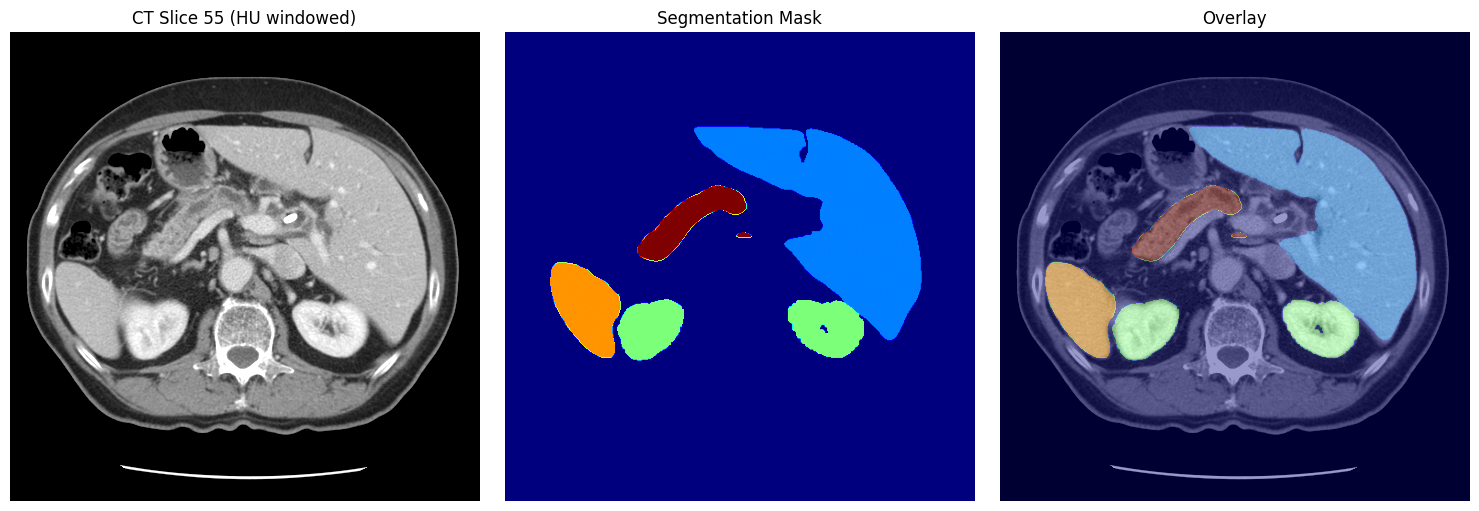


DATASET STATISTICS (sampling first 50 cases)

Volume Shape Statistics (W x H x D):
  Mean:   [512.0, 512.0, 88.5]
  Std:    [0.0, 0.0, 24.4]
  Min:    [512 512  37]
  Max:    [512 512 174]

Voxel Spacing Statistics (x, y, z in mm):
  Mean:   [0.793, 0.793, 2.985]
  Std:    [0.087, 0.087, 1.100]
  Min:    [0.613, 0.613, 1.250]
  Max:    [0.977, 0.977, 5.000]

Hounsfield Unit Statistics:
  Min HU (across volumes):  -1024.0
  Max HU (across volumes):  3071.0
  Mean HU (average):        -564.7

Organ Label Distribution (in 50 sampled cases):
  Label 0 (Background): appears in 50/50 cases
  Label 1 (Liver): appears in 50/50 cases
  Label 2 (Right Kidney): appears in 50/50 cases
  Label 3 (Left Kidney): appears in 50/50 cases
  Label 4 (Unknown_4): appears in 50/50 cases


In [0]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# ============================================
# DATA EXPLORATION FOR ABDOMINAL CT DATASET
# Supports both Subtask1 and AbdomenCT-1K formats
# ============================================

# Set data path - UPDATE THIS TO YOUR DATA LOCATION!
# Default: Subtask1 format at /dbfs/tmp/html_output/data
data_root = Path("/dbfs/tmp/html_output/data")

# Detect dataset format
if (data_root / "Subtask1").exists():
    print("Detected: Subtask1 format")
    image_dir = data_root / "Subtask1" / "TrainImage"
    mask_dir = data_root / "Subtask1" / "TrainMask"
    
    # Get all image files
    image_files = sorted(list(image_dir.glob("train_*_0000.nii.gz")))
    
    # Create pairs
    pairs = []
    for img_file in image_files:
        match = re.search(r'train_(\d+)_0000', img_file.name)
        if match:
            case_num = match.group(1)
            mask_file = mask_dir / f"train_{case_num}.nii.gz"
            if mask_file.exists():
                pairs.append((img_file, mask_file, f"train_{case_num}"))
    
    print(f"Total cases: {len(pairs)}")
    
else:
    print("Detected: AbdomenCT-1K format")
    case_dirs = sorted(list(data_root.glob("Case_*")))
    pairs = []
    for case_dir in case_dirs:
        ct_path = case_dir / "imaging.nii.gz"
        seg_path = case_dir / "segmentation.nii.gz"
        if ct_path.exists() and seg_path.exists():
            pairs.append((ct_path, seg_path, case_dir.name))
    
    print(f"Total cases: {len(pairs)}")

# Load one example case
if len(pairs) == 0:
    print("\nERROR: No data found! Please check your data path.")
    print(f"Looking in: {data_root}")
else:
    ct_path, seg_path, case_id = pairs[0]
    print(f"\nExploring: {case_id}")
    
    # Load CT image
    ct_nib = nib.load(ct_path)
    ct_data = ct_nib.get_fdata()
    
    # Load segmentation
    seg_nib = nib.load(seg_path)
    seg_data = seg_nib.get_fdata()
    
    # Print basic info
    print(f"\nCT Image Shape: {ct_data.shape}")
    print(f"Segmentation Shape: {seg_data.shape}")
    print(f"CT Value Range: [{ct_data.min():.1f}, {ct_data.max():.1f}] HU")
    print(f"Unique Labels: {np.unique(seg_data).astype(int)}")
    print(f"Voxel Spacing: {ct_nib.header.get_zooms()}")
    
    # Visualize middle axial slice
    slice_idx = ct_data.shape[2] // 2
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # CT slice
    axes[0].imshow(ct_data[:, :, slice_idx].T, cmap='gray', origin='lower', vmin=-160, vmax=240)
    axes[0].set_title(f'CT Slice {slice_idx} (HU windowed)')
    axes[0].axis('off')
    
    # Segmentation mask
    axes[1].imshow(seg_data[:, :, slice_idx].T, cmap='jet', origin='lower')
    axes[1].set_title('Segmentation Mask')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(ct_data[:, :, slice_idx].T, cmap='gray', origin='lower', vmin=-160, vmax=240)
    axes[2].imshow(seg_data[:, :, slice_idx].T, cmap='jet', alpha=0.4, origin='lower')
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('../results/visualizations/data_exploration_example.png', dpi=150, bbox_inches='tight')
    print("\nVisualization saved to: results/visualizations/data_exploration_example.png")
    plt.show()
    
    # Analyze dataset statistics (sample first 50 cases for speed)
    print("\n" + "="*60)
    print("DATASET STATISTICS (sampling first 50 cases)")
    print("="*60)
    
    shapes = []
    spacings = []
    organ_counts = {}
    hu_stats = {'min': [], 'max': [], 'mean': []}
    
    sample_size = min(50, len(pairs))
    
    for ct_path, seg_path, case_id in pairs[:sample_size]:
        try:
            ct_nib = nib.load(ct_path)
            seg_nib = nib.load(seg_path)
            
            shapes.append(ct_nib.shape)
            spacings.append(ct_nib.header.get_zooms())
            
            # HU statistics
            ct_array = ct_nib.get_fdata()
            hu_stats['min'].append(ct_array.min())
            hu_stats['max'].append(ct_array.max())
            hu_stats['mean'].append(ct_array.mean())
            
            # Organ labels
            unique_labels = np.unique(seg_nib.get_fdata()).astype(int)
            for label in unique_labels:
                organ_counts[label] = organ_counts.get(label, 0) + 1
        except Exception as e:
            print(f"Error processing {case_id}: {e}")
    
    shapes = np.array(shapes)
    spacings = np.array(spacings)
    
    print(f"\nVolume Shape Statistics (W x H x D):")
    print(f"  Mean:   [{shapes.mean(axis=0)[0]:.1f}, {shapes.mean(axis=0)[1]:.1f}, {shapes.mean(axis=0)[2]:.1f}]")
    print(f"  Std:    [{shapes.std(axis=0)[0]:.1f}, {shapes.std(axis=0)[1]:.1f}, {shapes.std(axis=0)[2]:.1f}]")
    print(f"  Min:    {shapes.min(axis=0)}")
    print(f"  Max:    {shapes.max(axis=0)}")
    
    print(f"\nVoxel Spacing Statistics (x, y, z in mm):")
    print(f"  Mean:   [{spacings.mean(axis=0)[0]:.3f}, {spacings.mean(axis=0)[1]:.3f}, {spacings.mean(axis=0)[2]:.3f}]")
    print(f"  Std:    [{spacings.std(axis=0)[0]:.3f}, {spacings.std(axis=0)[1]:.3f}, {spacings.std(axis=0)[2]:.3f}]")
    print(f"  Min:    [{spacings.min(axis=0)[0]:.3f}, {spacings.min(axis=0)[1]:.3f}, {spacings.min(axis=0)[2]:.3f}]")
    print(f"  Max:    [{spacings.max(axis=0)[0]:.3f}, {spacings.max(axis=0)[1]:.3f}, {spacings.max(axis=0)[2]:.3f}]")
    
    print(f"\nHounsfield Unit Statistics:")
    print(f"  Min HU (across volumes):  {np.min(hu_stats['min']):.1f}")
    print(f"  Max HU (across volumes):  {np.max(hu_stats['max']):.1f}")
    print(f"  Mean HU (average):        {np.mean(hu_stats['mean']):.1f}")
    
    print(f"\nOrgan Label Distribution (in {sample_size} sampled cases):")
    label_names = {0: "Background", 1: "Liver", 2: "Right Kidney", 3: "Left Kidney", 6: "Spleen"}
    for label in sorted(organ_counts.keys()):
        label_name = label_names.get(label, f"Unknown_{label}")
        print(f"  Label {label} ({label_name}): appears in {organ_counts[label]}/{sample_size} cases")
